# Análisis Predictivo - Predicción de cantidad de clientes por estado por los siguientes 6 meses

## Configuración inicial

In [1]:
# Ejecutar en Jupyter con un kernel que tenga PySpark instalado.
from pyspark.sql import SparkSession
from pyspark.sql import functions as F
from pyspark.sql.window import Window
import pandas as pd
import numpy as np
import os
import math
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")
import logging
logging.getLogger("cmdstanpy").setLevel(logging.WARNING)

# Path del parquet
PARQUET_PATH = "../data/olist_unified_dataset.parquet"

# Parámetros que se puede ajustar
MIN_MONTHS_PER_STATE = 12         # eliminar estados con menos meses de historico
EDGE_COUNT_THRESHOLD = 5          # si el primer/último mes de un estado tiene <= este valor, lo marcamos como erróneo y lo eliminamos de la serie
MIN_MEAN_FRACTION = 0.1         # si el primer/ultimo mes < MIN_MEAN_FRACTION * mean(series), también lo consideramos erróneo
FORECAST_HORIZON = 6              # meses a predecir
RANDOM_SEED = 42

print("Configuración lista. PARQUET_PATH =", PARQUET_PATH)


Configuración lista. PARQUET_PATH = ../data/olist_unified_dataset.parquet


## Pyspark session y carga

In [2]:
spark = SparkSession.builder \
    .appName("ForecastClientesPorEstado") \
    .config("spark.sql.shuffle.partitions", "8") \
    .getOrCreate()

df = spark.read.parquet(PARQUET_PATH)
print("Esquema:")
df.printSchema()
print("Filas totales:", df.count())

Esquema:
root
 |-- order_id: string (nullable = true)
 |-- customer_id: string (nullable = true)
 |-- order_status: string (nullable = true)
 |-- order_purchase_timestamp: timestamp_ntz (nullable = true)
 |-- order_approved_at: timestamp_ntz (nullable = true)
 |-- order_delivered_carrier_date: timestamp_ntz (nullable = true)
 |-- order_delivered_customer_date: timestamp_ntz (nullable = true)
 |-- order_estimated_delivery_date: timestamp_ntz (nullable = true)
 |-- customer_unique_id: string (nullable = true)
 |-- customer_zip_code_prefix: long (nullable = true)
 |-- customer_city: string (nullable = true)
 |-- customer_state: string (nullable = true)
 |-- order_item_id: double (nullable = true)
 |-- product_id: string (nullable = true)
 |-- seller_id: string (nullable = true)
 |-- shipping_limit_date: string (nullable = true)
 |-- price: double (nullable = true)
 |-- freight_value: double (nullable = true)
 |-- product_category_name: string (nullable = true)
 |-- product_name_lenght: do

## Preparando fecha y agrupar por mes + estado (conteo de clientes únicos por mes)

In [3]:
# Usamos customer_unique_id para contar clientes únicos por mes en cada estado
df2 = df.withColumn("order_year", F.year("order_purchase_timestamp")) \
        .withColumn("order_month", F.month("order_purchase_timestamp")) \
        .withColumn("year_month", F.date_trunc("month", F.col("order_purchase_timestamp")))

agg = df2.groupBy("customer_state", "year_month") \
         .agg(F.countDistinct("customer_unique_id").alias("num_customers")) \
         .orderBy("customer_state", "year_month")

print("Ejemplo de agregación (primeros 20):")
agg.show(20, False)

Ejemplo de agregación (primeros 20):
+--------------+-------------------+-------------+
|customer_state|year_month         |num_customers|
+--------------+-------------------+-------------+
|AC            |2017-01-01 00:00:00|1            |
|AC            |2017-02-01 00:00:00|3            |
|AC            |2017-03-01 00:00:00|2            |
|AC            |2017-04-01 00:00:00|5            |
|AC            |2017-05-01 00:00:00|8            |
|AC            |2017-06-01 00:00:00|4            |
|AC            |2017-07-01 00:00:00|5            |
|AC            |2017-08-01 00:00:00|4            |
|AC            |2017-09-01 00:00:00|5            |
|AC            |2017-10-01 00:00:00|6            |
|AC            |2017-11-01 00:00:00|5            |
|AC            |2017-12-01 00:00:00|5            |
|AC            |2018-01-01 00:00:00|6            |
|AC            |2018-02-01 00:00:00|3            |
|AC            |2018-03-01 00:00:00|2            |
|AC            |2018-04-01 00:00:00|4        

## Convertir a pandas por estado y construir series con index mensual (sin huecos)

In [4]:
# Convertimos la tabla agregada a pandas (puede ser grande: si el dataset es enorme, procesar por particiones)
pdf = agg.toPandas()
# Asegurarnos de tipo datetime para year_month
pdf['year_month'] = pd.to_datetime(pdf['year_month']).dt.to_period('M').dt.to_timestamp()

# Construir series para cada estado en un dict: {estado: pd.Series(index=month_ts, values=num_customers)}
states = pdf['customer_state'].unique().tolist()
print("Estados detectados:", len(states))

state_series = {}
for s in states:
    sub = pdf[pdf['customer_state'] == s].copy()
    if sub.shape[0] == 0:
        continue
    sub = sub.set_index('year_month').sort_index()
    # reindex con el rango completo de meses del primer al último
    full_idx = pd.date_range(start=sub.index.min(), end=sub.index.max(), freq='MS')
    ser = sub['num_customers'].reindex(full_idx).astype('float')
    ser.index.name = 'year_month'
    state_series[s] = ser

Estados detectados: 27


## Función de limpieza

In [5]:
# Función de limpieza más flexible: evita eliminar demasiados meses de inicio/fin
def clean_series_edge_noise(ser, edge_threshold=0, min_mean_frac=0.0, min_months=12):
    """
    Limpia la serie eliminando valores extremos al inicio y fin de la serie,
    pero mantiene la mayor cantidad de histórico posible.
    
    Parámetros:
        ser : pd.Series con índice datetime
        edge_threshold : valor mínimo absoluto para considerar válido
        min_mean_frac : fracción mínima de la media para considerar válido
        min_months : mínimo de meses requeridos para mantener la serie
        
    Retorna:
        Serie interpolada o None si no cumple el mínimo de meses
    """
    s = ser.copy()
    s_inter = s.interpolate(limit_direction='both')
    mean_val = s_inter.mean()
    
    # Validar índices
    if s.first_valid_index() is None or s.last_valid_index() is None:
        return None
    
    first_idx = s.first_valid_index()
    last_idx = s.last_valid_index()
    
    # Solo eliminar bordes si son cero o extremadamente bajos
    if (not pd.isna(s.loc[first_idx])) and (s.loc[first_idx] <= edge_threshold or s.loc[first_idx] <= min_mean_frac * mean_val):
        s.loc[first_idx] = np.nan
    if (not pd.isna(s.loc[last_idx])) and (s.loc[last_idx] <= edge_threshold or s.loc[last_idx] <= min_mean_frac * mean_val):
        s.loc[last_idx] = np.nan
    
    # Interpolar después de limpiar
    s_clean = s.interpolate(limit_direction='both')
    
    # Verificar mínimo de meses
    valid_months = s_clean.dropna().shape[0]
    if valid_months < min_months:
        return None
    
    return s_clean

# ================= Aplicar limpieza a cada estado =================
cleaned_state_series = {}
removed_states = []

for s, ser in state_series.items():
    cleaned = clean_series_edge_noise(ser, edge_threshold=EDGE_COUNT_THRESHOLD,
                                      min_mean_frac=MIN_MEAN_FRACTION,
                                      min_months=MIN_MONTHS_PER_STATE)
    if cleaned is None:
        removed_states.append(s)
    else:
        cleaned_state_series[s] = cleaned

print(f"Estados originales: {len(state_series)}. Eliminados por poco historial o ruido en bordes: {len(removed_states)}")
print("Estados eliminados (ejemplos):", removed_states[:10])

# ================= Verificación de rangos de fechas =================
for s, ser in cleaned_state_series.items():
    print(f"{s}: {ser.index.min().strftime('%Y-%m')} a {ser.index.max().strftime('%Y-%m')}, {len(ser)} meses")


Estados originales: 27. Eliminados por poco historial o ruido en bordes: 0
Estados eliminados (ejemplos): []
AC: 2017-01 a 2018-08, 20 meses
AL: 2016-10 a 2018-08, 23 meses
AM: 2017-02 a 2018-08, 19 meses
AP: 2017-02 a 2018-08, 19 meses
BA: 2016-10 a 2018-08, 23 meses
CE: 2016-10 a 2018-08, 23 meses
DF: 2016-10 a 2018-08, 23 meses
ES: 2016-10 a 2018-08, 23 meses
GO: 2016-10 a 2018-08, 23 meses
MA: 2016-10 a 2018-08, 23 meses
MG: 2016-10 a 2018-08, 23 meses
MS: 2017-01 a 2018-08, 20 meses
MT: 2016-10 a 2018-08, 23 meses
PA: 2016-10 a 2018-08, 23 meses
PB: 2016-10 a 2018-08, 23 meses
PE: 2016-10 a 2018-08, 23 meses
PI: 2016-10 a 2018-08, 23 meses
PR: 2016-10 a 2018-08, 23 meses
RJ: 2016-10 a 2018-08, 23 meses
RN: 2016-10 a 2018-08, 23 meses
RO: 2017-01 a 2018-08, 20 meses
RR: 2016-09 a 2018-07, 23 meses
RS: 2016-09 a 2018-08, 24 meses
SC: 2016-10 a 2018-08, 23 meses
SE: 2016-10 a 2018-08, 23 meses
SP: 2016-09 a 2018-09, 25 meses
TO: 2017-01 a 2018-08, 20 meses


## Mostrar un plot de ejemplo para 3 estados con historico

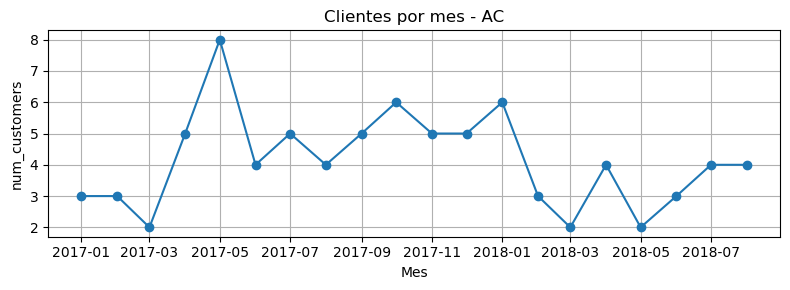

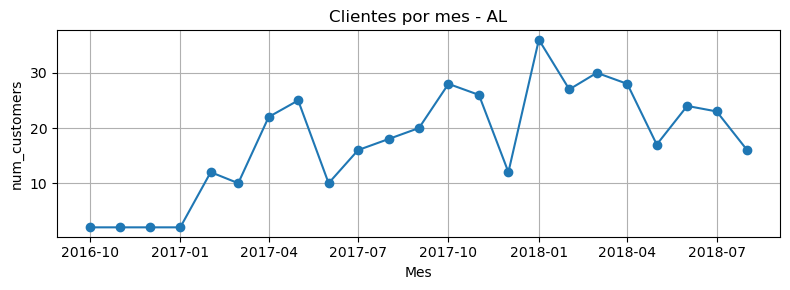

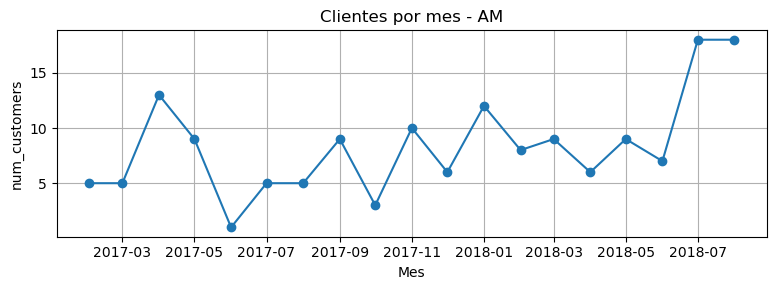

In [6]:
sample_states = list(cleaned_state_series.keys())[:3]
for s in sample_states:
    ser = cleaned_state_series[s]
    plt.figure(figsize=(8,3))
    plt.plot(ser.index, ser.values, marker='o')
    plt.title(f"Clientes por mes - {s}")
    plt.xlabel("Mes")
    plt.ylabel("num_customers")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

## Utilizando MAPE, RMSE

In [7]:
from sklearn.metrics import mean_squared_error

def mape(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    # evitar dibacktest_and_forecastvision por 0: si true=0, ignorar esos puntos en MAPE
    mask = y_true != 0
    if mask.sum() == 0:
        return np.nan
    return np.mean(np.abs((y_true[mask] - y_pred[mask]) / y_true[mask])) * 100

def rmse(y_true, y_pred):
    return math.sqrt(mean_squared_error(y_true, y_pred))

## Funciones de forecasting robustas

In [8]:
try:
    from prophet import Prophet
    HAS_PROPHET = True
except Exception:
    try:
        from fbprophet import Prophet
        HAS_PROPHET = True
    except Exception:
        HAS_PROPHET = False

print("Prophet disponible:", HAS_PROPHET)

from statsmodels.tsa.statespace.sarimax import SARIMAX
import itertools

# ------------------ SARIMAX ------------------
def select_sarimax_order(y, p_max=2, d_max=1, q_max=2):
    """Selecciona orden simple para series cortas"""
    best_aic = np.inf
    best_order = (1,0,1)
    for p,q in itertools.product(range(p_max+1), range(q_max+1)):
        for d in range(d_max+1):
            try:
                model = SARIMAX(y, order=(p,d,q), enforce_stationarity=False, enforce_invertibility=False)
                res = model.fit(disp=False, maxiter=50)
                if res.aic < best_aic:
                    best_aic = res.aic
                    best_order = (p,d,q)
            except Exception:
                continue
    return best_order

def forecast_with_sarimax(series, horizon=6, order=(1,0,1)):
    y = series.astype('float').dropna()
    model = SARIMAX(y, order=order,
                    enforce_stationarity=False,
                    enforce_invertibility=False)
    res = model.fit(disp=False, maxiter=100)
    fc = res.get_forecast(steps=horizon).predicted_mean
    fc.index = pd.date_range(start=y.index.max() + pd.offsets.MonthBegin(1),
                             periods=horizon, freq='MS')
    return fc


# ------------------ Prophet ------------------
def forecast_with_prophet(series, horizon=FORECAST_HORIZON):
    dfp = series.astype('float').reset_index()
    dfp.columns = ['ds', 'y']
    m = Prophet(yearly_seasonality=True, weekly_seasonality=False, daily_seasonality=False)
    m.fit(dfp)
    future = m.make_future_dataframe(periods=horizon, freq='MS')
    fc = m.predict(future)
    fc = fc[['ds','yhat']].set_index('ds').yhat
    fc = np.maximum(fc, 0.0)
    return fc

Importing plotly failed. Interactive plots will not work.


Prophet disponible: True


## Aplicando forecast sobre train y toda la serie

In [9]:
def backtest_and_forecast(series, horizon=FORECAST_HORIZON, use_prophet=HAS_PROPHET):
    s = series.astype('float').asfreq('MS').dropna()
    
    # mínimo histórico para backtest
    if len(s) < max(horizon + 6, 12):
        return None
    
    train = s[:-horizon]
    test = s[-horizon:]
    
    # ----------------- Forecast sobre train -----------------
    try:
        if use_prophet:
            fc_all = forecast_with_prophet(train, horizon=horizon)
        else:
            fc_all = forecast_with_sarimax(train, horizon=horizon)
        preds = fc_all[-horizon:].values
    except Exception:
        # fallback SARIMAX
        fc_all = forecast_with_sarimax(train, horizon=horizon)
        preds = fc_all[-horizon:].values
    
    # asegurar valores no negativos
    preds = np.maximum(preds, 0.0)
    
    # calcular métricas
    metrics = {
        'rmse': rmse(test.values, preds),
        'mape': mape(test.values, preds)
    }
    
    # ----------------- Forecast sobre toda la serie -----------------
    try:
        if use_prophet:
            full_fc = forecast_with_prophet(s, horizon=horizon)
        else:
            full_fc = forecast_with_sarimax(s, horizon=horizon)
        full_fc = np.maximum(full_fc, 0.0)
        forecast_series = pd.Series(full_fc.values, index=full_fc.index)
    except Exception:
        # fallback simple SARIMAX
        full_fc = forecast_with_sarimax(s, horizon=horizon)
        forecast_series = pd.Series(np.maximum(full_fc.values,0.0), index=full_fc.index)
    
    return {'metrics': metrics, 'forecast': forecast_series}

## Ejecución por estado

In [10]:
results = {}
skipped = []

for s, ser in cleaned_state_series.items():
    try:
        res = backtest_and_forecast(ser, horizon=FORECAST_HORIZON)
        if res is None:
            skipped.append(s)
        else:
            results[s] = res
    except Exception as e:
        skipped.append(s)

print("Estados con resultado:", len(results))
print("Ejemplos de estados con forecast:", list(results.keys())[:10])
print("Estados saltados:", len(skipped))

22:35:25 - cmdstanpy - INFO - Chain [1] start processing
22:35:26 - cmdstanpy - INFO - Chain [1] done processing
22:35:26 - cmdstanpy - INFO - Chain [1] start processing
22:35:34 - cmdstanpy - INFO - Chain [1] done processing
22:35:34 - cmdstanpy - INFO - Chain [1] start processing
22:35:44 - cmdstanpy - INFO - Chain [1] done processing
22:35:44 - cmdstanpy - INFO - Chain [1] start processing
22:35:44 - cmdstanpy - INFO - Chain [1] done processing
22:35:44 - cmdstanpy - INFO - Chain [1] start processing
22:35:46 - cmdstanpy - INFO - Chain [1] done processing
22:35:46 - cmdstanpy - INFO - Chain [1] start processing
22:35:50 - cmdstanpy - INFO - Chain [1] done processing
22:35:50 - cmdstanpy - INFO - Chain [1] start processing
22:35:58 - cmdstanpy - INFO - Chain [1] done processing
22:35:59 - cmdstanpy - INFO - Chain [1] start processing
22:36:10 - cmdstanpy - INFO - Chain [1] done processing
22:36:10 - cmdstanpy - INFO - Chain [1] start processing
22:36:11 - cmdstanpy - INFO - Chain [1]

Estados con resultado: 27
Ejemplos de estados con forecast: ['AC', 'AL', 'AM', 'AP', 'BA', 'CE', 'DF', 'ES', 'GO', 'MA']
Estados saltados: 0


## Resumen de métricas

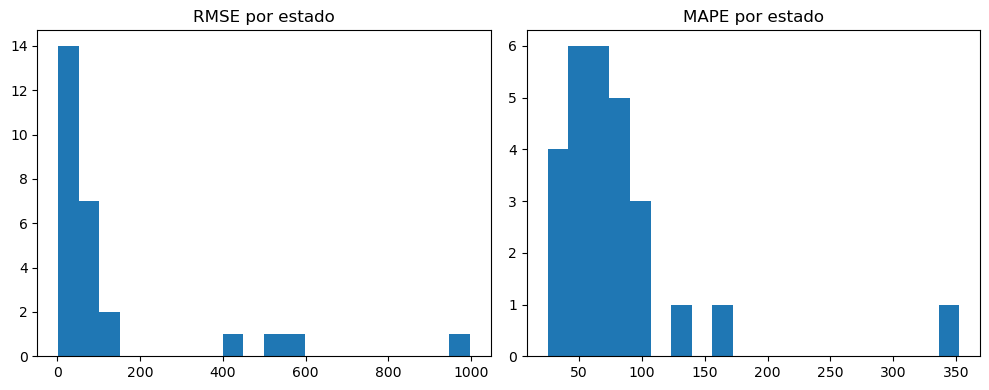

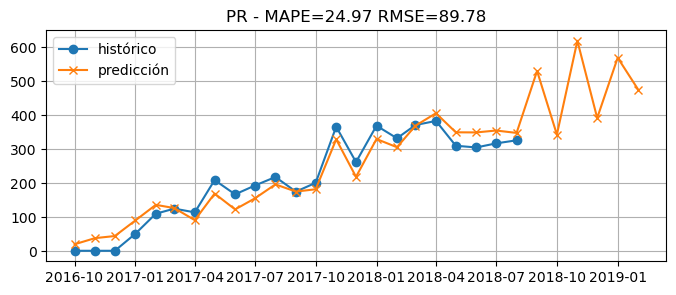

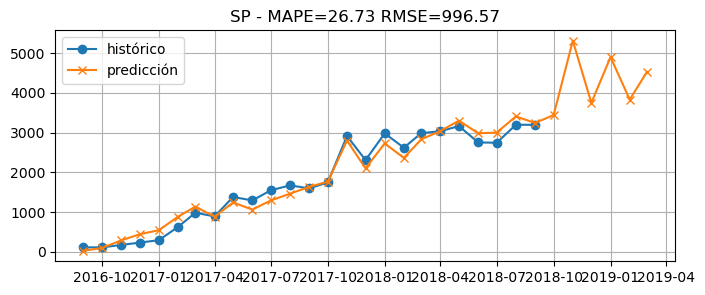

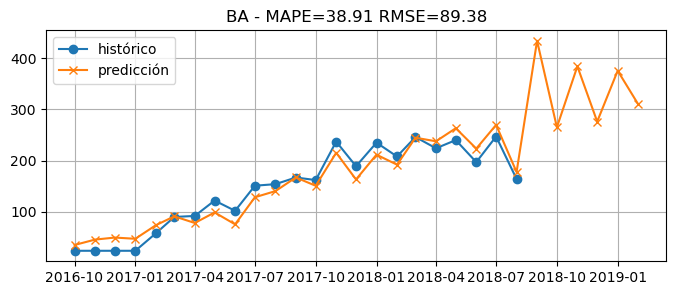

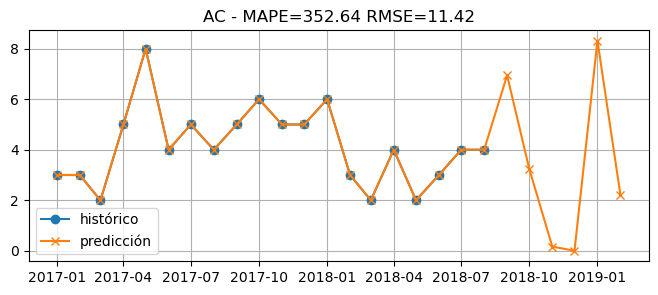

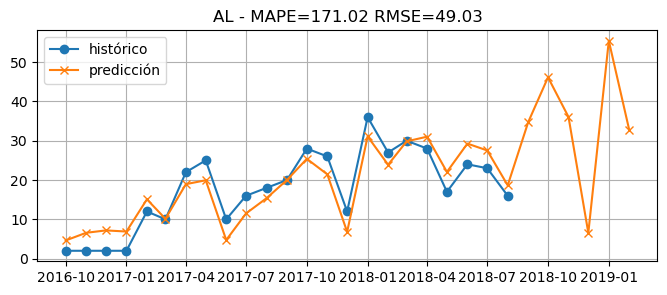

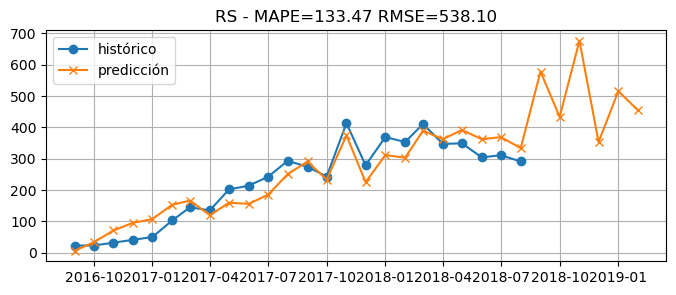

In [11]:
# Crear dataframe de métricas
rows = []
for s, v in results.items():
    rows.append((s, v['metrics']['rmse'], v['metrics']['mape']))

metrics_df = pd.DataFrame(rows, columns=['state','rmse','mape'])

# Mostrar histogramas de métricas si hay datos
if not metrics_df.empty:
    plt.figure(figsize=(10,4))
    plt.subplot(1,2,1)
    plt.hist(metrics_df['rmse'].dropna(), bins=20)
    plt.title('RMSE por estado')
    plt.subplot(1,2,2)
    plt.hist(metrics_df['mape'].dropna(), bins=20)
    plt.title('MAPE por estado')
    plt.tight_layout()
    plt.show()

    # Mostrar ejemplos: top 3 mejores y peores por MAPE
    best = metrics_df.dropna().sort_values('mape').head(3)['state'].tolist()
    worst = metrics_df.dropna().sort_values('mape', ascending=False).head(3)['state'].tolist()

    for s in best + worst:
        ser = cleaned_state_series[s]
        fc = results[s]['forecast']
        plt.figure(figsize=(8,3))
        plt.plot(ser.index, ser.values, label='histórico', marker='o')
        plt.plot(fc.index, fc.values, label='predicción', marker='x')
        plt.title(f"{s} - MAPE={results[s]['metrics']['mape']:.2f} RMSE={results[s]['metrics']['rmse']:.2f}")
        plt.legend()
        plt.grid(True)
        plt.show()
else:
    print("No hay métricas para mostrar. Verifica que results no esté vacío.")

## Consolidar las predicciones en un DataFrame y exportar a CSV

In [12]:
pred_rows = []
for s, v in results.items():
    fc = v['forecast']
    for idx, val in fc.items():
        pred_rows.append({
            'customer_state': s,
            'year_month': pd.to_datetime(idx).strftime('%Y-%m-01'),
            'predicted_num_customers': float(val),
            'rmse': float(v['metrics']['rmse']),
            'mape': float(v['metrics']['mape'])
        })

pred_df = pd.DataFrame(pred_rows)
pred_df = pred_df.sort_values(['customer_state','year_month'])
print("Predicciones (muestra):")
print(pred_df.head(12))

# Guardar CSV localmente
out_path = "../results/predicted_customers_by_state_next6months.csv"
pred_df.to_csv(out_path, index=False)
print("Exportado:", out_path)

Predicciones (muestra):
   customer_state  year_month  predicted_num_customers      rmse        mape
0              AC  2017-01-01                 3.000001  11.42305  352.636775
1              AC  2017-02-01                 3.000000  11.42305  352.636775
2              AC  2017-03-01                 1.999999  11.42305  352.636775
3              AC  2017-04-01                 5.000000  11.42305  352.636775
4              AC  2017-05-01                 8.000000  11.42305  352.636775
5              AC  2017-06-01                 4.000001  11.42305  352.636775
6              AC  2017-07-01                 5.000000  11.42305  352.636775
7              AC  2017-08-01                 4.000001  11.42305  352.636775
8              AC  2017-09-01                 5.000000  11.42305  352.636775
9              AC  2017-10-01                 5.999999  11.42305  352.636775
10             AC  2017-11-01                 5.000001  11.42305  352.636775
11             AC  2017-12-01                 5.0000

## Resumen Ejecutivo

In [13]:
print("="*70)
print("RESUMEN EJECUTIVO - MODELO DE PREDICCIÓN DE CLIENTES POR ESTADO")
print("="*70)

pred_df['year_month_dt'] = pd.to_datetime(pred_df['year_month'])
historical_end = pred_df['year_month_dt'].max() - pd.DateOffset(months=FORECAST_HORIZON)
forecast_start = historical_end + pd.DateOffset(months=1)
forecast_end = pred_df['year_month_dt'].max()

# Datos
first_date = pred_df['year_month_dt'].min()
last_date = historical_end
num_months = ((last_date - first_date).days // 30) + 1
print("DATOS UTILIZADOS")
print(f"  • Periodo histórico: {first_date.strftime('%Y-%m')} a {last_date.strftime('%Y-%m')}")
print(f"  • Total de meses históricos: {num_months}")
print(f"  • Granularidad: Mensual")
print(f"  • Variable objetivo: Número de clientes únicos por estado")
print()

# Modelo
print("MODELO")
print("  • Algoritmo: SARIMAX (Statsmodels)")
print("  • Algoritmo: PROPHET")
print("  • Componentes: Autorregresivo + Media móvil + Estacionalidad mensual si aplicable")
print()

# Métricas
print("PERFORMANCE EN TEST SET")
mape_mean = metrics_df['mape'].mean()
rmse_mean = metrics_df['rmse'].mean()
print(f"  • MAPE promedio por estado: {mape_mean:.2f}%")
print(f"  • RMSE promedio por estado: {rmse_mean:.2f} clientes")
print()

# Pronóstico
forecast_df = pred_df[pred_df['year_month_dt'] > historical_end]
total_forecast = forecast_df['predicted_num_customers'].sum()
print("PRONÓSTICO PRÓXIMOS 6 MESES")
print(f"  • Periodo: {forecast_start.strftime('%Y-%m')} a {forecast_end.strftime('%Y-%m')}")
print(f"  • Clientes totales esperados: {int(total_forecast)}")
print(f"  • Escenario pesimista (-10%): {int(total_forecast*0.9)}")
print(f"  • Escenario optimista (+10%): {int(total_forecast*1.1)}")
print()

# Insights
top_state = forecast_df.groupby('customer_state')['predicted_num_customers'].sum().idxmax()
top_month = forecast_df.groupby('year_month_dt')['predicted_num_customers'].sum().idxmax()
print("INSIGHTS CLAVE")
print(f"  • Estado con más clientes proyectados: {top_state}")
print(f"  • Mes con mayor número de clientes proyectado: {top_month.strftime('%Y-%m')}")
print("  • Tendencia general: Incremento/estabilidad según patrones históricos y forecast")
print()

# Recomendaciones
print("RECOMENDACIONES")
print("  1. Preparar recursos y marketing según estados con mayor crecimiento")
print("  2. Monitorear meses pico (meses con más clientes proyectados)")
print("  3. Ajustar campañas o inventario según proyecciones por estado")
print("  4. Revisar forecasts mensualmente y actualizar con nuevos datos históricos")
print("  5. Considerar la posible volatilidad en meses futuros debido a la extrapolación de tendencias y estacionalidades, y ajustar decisiones operativas con prudencia.")
print("="*70)

RESUMEN EJECUTIVO - MODELO DE PREDICCIÓN DE CLIENTES POR ESTADO
DATOS UTILIZADOS
  • Periodo histórico: 2016-09 a 2018-09
  • Total de meses históricos: 25
  • Granularidad: Mensual
  • Variable objetivo: Número de clientes únicos por estado

MODELO
  • Algoritmo: SARIMAX (Statsmodels)
  • Algoritmo: PROPHET
  • Componentes: Autorregresivo + Media móvil + Estacionalidad mensual si aplicable

PERFORMANCE EN TEST SET
  • MAPE promedio por estado: 82.10%
  • RMSE promedio por estado: 132.46 clientes

PRONÓSTICO PRÓXIMOS 6 MESES
  • Periodo: 2018-10 a 2019-03
  • Clientes totales esperados: 53390
  • Escenario pesimista (-10%): 48051
  • Escenario optimista (+10%): 58730

INSIGHTS CLAVE
  • Estado con más clientes proyectados: SP
  • Mes con mayor número de clientes proyectado: 2018-11
  • Tendencia general: Incremento/estabilidad según patrones históricos y forecast

RECOMENDACIONES
  1. Preparar recursos y marketing según estados con mayor crecimiento
  2. Monitorear meses pico (meses co